# M23AIR010_M23AIR013_M23ARI007


# DL_Assignment: 4

In [8]:
import os
import math
import wandb
import pandas as pd
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.models import inception_v3
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch.optim as optim
from torchvision import datasets, models
from sklearn.metrics import accuracy_score

In [9]:
# Define paths
train_data_path = 'Train/Sample_data/Train_data/'
train_sketch_path = 'Train/Sample_data/Train_contours/'
train_labels_path = 'Train/Sample_data/Train_labels.csv'

test_data_path = 'Test/Sample_data/Test_data/'
test_sketch_path = 'Test/Sample_data/Test_contours/'
test_labels_path = 'Test/Sample_data/Test_labels.csv'

# Read train labels
train_labels_df = pd.read_csv(train_labels_path)

# Read test labels
test_labels_df = pd.read_csv(test_labels_path)

# Image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to range [-1, 1]
])

# Function to preprocess ISIC images and store them in memory
def preprocess_isic_images(data_path, labels_df):
    processed_images = []
    processed_labels = []
    for index, row in labels_df.iterrows():
        image_name = row['image']
        image_path = os.path.join(data_path, image_name + '.jpg')
        image = Image.open(image_path)  # Assuming image format is jpg
        image = transform(image)
        processed_images.append(image)
        label_values = row[1:].values.astype(int)  # Convert labels to integers
        processed_labels.append(torch.tensor(label_values))  # Convert labels to tensor
    return torch.stack(processed_images), torch.stack(processed_labels)

# Preprocess train ISIC images
train_images, train_labels = preprocess_isic_images(train_data_path, train_labels_df)
print("Train ISIC images Loaded")

Train ISIC images Loaded


In [10]:
print(train_images.size()) 
print(train_labels.size())

torch.Size([95, 3, 256, 256])
torch.Size([95, 7])


In [11]:
# Convert train_labels to the range of 0 to 6
train_labels = torch.argmax(train_labels, dim=1)

In [13]:
train_labels

tensor([1, 1, 1, 1, 0, 1, 4, 0, 1, 0, 1, 1, 5, 1, 1, 1, 1, 0, 4, 1, 1, 1, 1, 3,
        5, 2, 2, 0, 1, 1, 4, 4, 4, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 4, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 6, 4, 3, 1, 1, 6, 1, 1,
        1, 1, 1, 4, 4, 4, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 0])

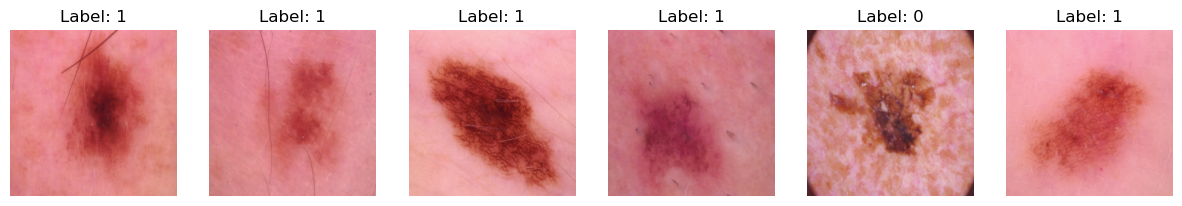

In [14]:
def plot_images(images, labels, num_images=6):
    # Set the number of images to plot
    num_images = min(num_images, images.size(0))
    
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 3))
    
    for i, ax in enumerate(axes.flat):
        if i >= num_images:
            break
        # Normalize image data to [0, 1] range
        image = (images[i].permute(1, 2, 0) + 1) / 2.0  # Normalize pixel values from [-1, 1] to [0, 1]
        
        # Display image
        ax.imshow(image)  
        ax.set_title(f"Label: {labels[i].item()}")  # Use item() to get the scalar value of the label tensor
        ax.axis('off')
    
    plt.show()

# Plot some of the images
plot_images(train_images, train_labels)

In [15]:
# Function to preprocess sketch images and store them in memory

# Sketch transformations with normalization
sketch_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to range [-1, 1] for grayscale images
])

def preprocess_sketch_images(sketch_path):
    processed_sketches = []
    for file in os.listdir(sketch_path):
        if file.endswith('.png'):
            sketch_file_path = os.path.join(sketch_path, file)
            sketch = Image.open(sketch_file_path)
            sketch = sketch_transform(sketch)
            processed_sketches.append(sketch)
    return torch.stack(processed_sketches)

# Preprocess train sketch images
train_sketches = preprocess_sketch_images(train_sketch_path)
print("Train sketches Loaded.")

Train sketches Loaded.


In [16]:
# # Random Lables for Sketches
n_classes = 7
total_no_sketches = train_sketches.size()[0]
sketch_labels = torch.randint(0, n_classes, (total_no_sketches,))  # Example labels for the batch
print(sketch_labels.size())

torch.Size([25])


In [ ]:
def plot_images(images, labels, num_images=6):
    # Set the number of images to plot
    num_images = min(num_images, images.size(0))
    
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 3))
    
    for i, ax in enumerate(axes.flat):
        if i >= num_images:
            break
        # Display image
        ax.imshow(images[i].permute(1, 2, 0))  # PyTorch tensors are in CxHxW format, but Matplotlib expects HxWxC
        ax.set_title(f"Label: {labels[i].numpy()}")
        ax.axis('off')
    
    plt.show()

# Assuming train_labels are your tensor of labels corresponding to each image
# Plot some of the images

plot_images(train_sketches, sketch_labels, num_images=5)

# Model -3 Final Model

In [18]:
# # Define your downsampler (encoder) function
# def downsample(in_channels, out_channels, kernel_size=4, stride=2, padding=1, apply_batchnorm=True):
#     layers = []
#     layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))
#     if apply_batchnorm:
#         layers.append(nn.BatchNorm2d(out_channels))
#     layers.append(nn.LeakyReLU(0.2))
#     return nn.Sequential(*layers)

# # Define your upsampler (decoder) function
# def upsample(in_channels, out_channels, kernel_size=4, stride=2, padding=1, apply_dropout=False):
#     layers = []
#     layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))
#     layers.append(nn.BatchNorm2d(out_channels))
#     if apply_dropout:
#         layers.append(nn.Dropout(0.5))
#     layers.append(nn.ReLU())
#     return nn.Sequential(*layers)

# class LabelEmbedding(nn.Module):
#     def __init__(self, n_classes=7, embedding_dim=256 * 256):
#         super(LabelEmbedding, self).__init__()
#         self.embedding = nn.Embedding(n_classes, embedding_dim)

#     def forward(self, labels):
#         # Embed the label and adjust its shape to match an image
#         embedded = self.embedding(labels)  # Shape: [batch_size, embedding_dim]
#         embedded = embedded.view(-1, 1, 256, 256)  # Shape: [batch_size, 1, 256, 256]
#         return embedded

# class Generator(nn.Module):
#     def __init__(self, n_classes, image_channels=1):
#         super(Generator, self).__init__()
#         self.label_embedding = LabelEmbedding(n_classes)

#         # Process combined image and label embedding
#         self.conv1 = nn.Conv2d(image_channels + 1, 64, kernel_size=4, stride=2, padding=1)  # Adjusted for input size
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU()

#         self.down_stack = nn.ModuleList([
#             downsample(64, 128, apply_batchnorm=False),
#             downsample(128, 256),
#             downsample(256, 512),
#             downsample(512, 512),
#             downsample(512, 512),
#             downsample(512, 512),
#             downsample(512, 512),
            
#         ])
        
#         self.up_stack = nn.ModuleList([
#             upsample(512, 512, apply_dropout=True),
#             upsample(1024, 512, apply_dropout=True),
#             upsample(1024, 512, apply_dropout=True),
#             upsample(1024, 512),
#             upsample(1024, 256),
#             upsample(512, 128),
#             upsample(256, 64),
            
#         ])

#         # Final output layer
#         self.last_1 = nn.ConvTranspose2d(256, 3, kernel_size=4, stride=2, padding=1)
#         self.last_2 = nn.ConvTranspose2d(3, 3, kernel_size=4, stride=2, padding=1)

#     def downsample(self, in_channels, out_channels, apply_batchnorm=True):
#         layers = [
#             nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True)
#         ]
#         if apply_batchnorm:
#             layers.append(nn.BatchNorm2d(out_channels))
#         return nn.Sequential(*layers)

#     def upsample(self, in_channels, out_channels, apply_dropout=False):
#         layers = [
#             nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.ReLU(inplace=True)
#         ]
#         if apply_dropout:
#             layers.append(nn.Dropout(0.5))
#         return nn.Sequential(*layers)

#     def forward(self, x, labels):
#         # Get the label embeddings
#         label_embed = self.label_embedding(labels)
#         # Concatenate the label embedding with the input image
#         x = torch.cat((x, label_embed), dim=1)
        
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
        
#         skips = []
#         for down in self.down_stack:
#             x = down(x)
#             skips.append(x)

#         skips = reversed(skips[:-1])

#         for up, skip in zip(self.up_stack, skips):
#             x = up(x)
#             x = torch.cat((x, skip), dim=1)

#         x = self.last_1(x)
#         x = torch.tanh(x)
#         x = self.last_2(x)
#         x = torch.tanh(x)
#         return x

# class Discriminator(nn.Module):
#     def __init__(self, n_classes):
#         super(Discriminator, self).__init__()

#         self.label_embedding = LabelEmbedding(n_classes)

#         self.down1 = downsample(4, 64, apply_batchnorm=False)
#         self.down2 = downsample(64, 128)
#         self.down3 = downsample(128, 256)

#         self.zero_pad1 = nn.ZeroPad2d(1)
#         self.conv = nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=0, bias=False)
#         self.batchnorm1 = nn.BatchNorm2d(512)
#         self.leaky_relu = nn.LeakyReLU(0.2)

#         self.zero_pad2 = nn.ZeroPad2d(1)
#         self.last = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)

#     def forward(self, inp, labels):
#         # Get the label embeddings
#         label_embed = self.label_embedding(labels)
#         # Concatenate input and label embedding
#         inp = torch.cat((inp, label_embed), dim=1)

#         x = self.down1(inp)
#         x = self.down2(x)
#         x = self.down3(x)

#         x = self.zero_pad1(x)
#         x = self.conv(x)
#         x = self.batchnorm1(x)
#         x = self.leaky_relu(x)

#         x = self.zero_pad2(x)
#         x = self.last(x)

#         return x

# def generator_loss(disc_generated_output, gen_output, target, lambda_val = 100):
    
#     # Binary cross-entropy loss (GAN loss)
#     gan_loss = F.binary_cross_entropy_with_logits(disc_generated_output, torch.ones_like(disc_generated_output))
    
#     # Mean absolute error (L1 loss)
#     l1_loss = F.l1_loss(gen_output, target)
    
#     # Total generator loss
#     total_gen_loss = gan_loss + (lambda_val * l1_loss)
    
#     return total_gen_loss, gan_loss, l1_loss

# def discriminator_loss(disc_real_output, disc_generated_output):
#     # Binary cross-entropy loss for real and generated outputs
#     real_loss = F.binary_cross_entropy_with_logits(disc_real_output, torch.ones_like(disc_real_output))
#     generated_loss = F.binary_cross_entropy_with_logits(disc_generated_output, torch.zeros_like(disc_generated_output))
    
#     # Total discriminator loss
#     total_disc_loss = (real_loss + generated_loss)/2
    
#     return total_disc_loss
    
# # Initialize the generator and discriminator
# # n_classes = 7
# generator = Generator(n_classes, 1) # no of channels 1
# discriminator = Discriminator(n_classes) # by default for channels 3

# # Define the optimizers
# optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [19]:
generator

Generator(
  (label_embedding): LabelEmbedding(
    (embedding): Embedding(7, 65536)
  )
  (conv1): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (down_stack): ModuleList(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3-6): 4 x Sequential(
      (0): Conv2d(512, 512, kernel_size=(4, 4), st

In [21]:
# Training of model 

wandb.login()

# Initialize WandB run
wandb.init(project="image_generation", entity="m23air010")

discriminator_losses = []
generator_losses = []
num_epochs = 5
LAMBDA = 100
batch_size = 64

# Data_loading and Training loop
total_part_image_data = math.ceil(train_images.size()[0]/total_no_sketches)
print("total_part_image_data: ", total_part_image_data)

# Create a Images TensorDataset
img_dataset = TensorDataset(train_images, train_labels)

# Create a Images DataLoader
image_data_loader = DataLoader(img_dataset, batch_size=total_no_sketches, shuffle=True)

gen_loss = []

for i, (batch_images, batch_image_labels) in enumerate(image_data_loader):
    print("Image part:", i + 1)
    
    if batch_images.size()[0] < total_no_sketches:
        batch_sketches = train_sketches[0 : batch_images.size()[0]]
        batch_sketch_labels = sketch_labels[0: batch_images.size()[0]]
        
        # Create a TensorDataset
        dataset = TensorDataset(batch_images, batch_image_labels, batch_sketches, batch_sketch_labels)
    
    else: 
        # Create a TensorDataset
        dataset = TensorDataset(batch_images, batch_image_labels, train_sketches, sketch_labels)

    # Create a DataLoader
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(num_epochs):
        print("")
        for j, (real_images, real_labels, sketch, skech_lab) in enumerate(train_loader):

            # Clear discriminator gradients
            discriminator.zero_grad()

            # Generate fake images from sketches
            print(skech_lab.shape)
            fake_images = generator(sketch, skech_lab.long())
            
            if epoch % 10 == 0 and j == 0:
                # Log generated images
                wandb.log({"generated_images": [wandb.Image(image) for image in fake_images]})
        

            # Discriminator predictions for real and fake images
            real_pred = discriminator(real_images, real_labels.long())

            # Calculate discriminator loss for fake images
            fake_pred = discriminator(fake_images.detach(), skech_lab.long())
            
            # Compute discriminator loss
            disc_loss = discriminator_loss(real_pred, fake_pred)
            
            # Log loss
            wandb.log({"discriminator_loss": disc_loss.item()})

            # Update discriminator weights
            disc_loss.backward()
            optimizer_D.step()

            # Clear generator gradients
            generator.zero_grad()
            
            # Generate fake images from sketches
            fake_images = generator(sketch, skech_lab.long())

            # Discriminator predictions for generated images
            fake_pred = discriminator(fake_images, skech_lab.long())
            
            # Compute generator loss
            total_gen_loss, gen_gan_loss, gen_l1_loss = generator_loss(fake_pred, fake_images, real_images, LAMBDA)
            
            # Log loss
            wandb.log({"generator_total_gen_loss": total_gen_loss.item()})
            # Log loss
            wandb.log({"generator_gan_loss": gen_gan_loss.item()})
            # Log loss
            wandb.log({"generator_l1_loss": gen_l1_loss.item()})
            
            
            
            # Update generator weights
            total_gen_loss.backward()
            optimizer_G.step()

            discriminator_losses.append(disc_loss.item())
            generator_losses.append([total_gen_loss, gen_gan_loss, gen_l1_loss])
            
            # Print training progress
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{j+1}/{len(train_loader)}], "
                  f"Discriminator Loss: {disc_loss.item():.4f}, Generator Loss: {gen_l1_loss.item():.4f}")
    print("")
print("Training finished!")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


discriminator_loss,▄█▂▁
generator_gan_loss,█▅▁
generator_l1_loss,█▄▁
generator_total_gen_loss,█▅▁
discriminator_loss,0.68228
generator_gan_loss,0.65215
generator_l1_loss,0.33372
generator_total_gen_loss,34.02374


total_part_image_data:  4
Image part: 1

torch.Size([25])
Epoch [1/5], Batch [1/1], Discriminator Loss: 0.6840, Generator Loss: 0.3239

torch.Size([25])
Epoch [2/5], Batch [1/1], Discriminator Loss: 0.6639, Generator Loss: 0.3115

torch.Size([25])


KeyboardInterrupt: 

In [ ]:
# Plot Generator Loss
import numpy as np

# # Load data from JSON file
# with open("outputs/generator_losses.json", "r") as file:
#     generator_losses = json.load(file)

# Extract each type of loss data
generator_total_gen_loss = [entry[0] for entry in generator_losses]
generator_gan_loss = [entry[1] for entry in generator_losses]
generator_l1_loss = [entry[2] for entry in generator_losses]

num_epochs = 150

def calculate_epoch_losses(loss):
    # Splitting into three parts
    part1 = loss[:num_epochs * 57]
    part2 = loss[num_epochs * 57: 2 * num_epochs * 57]
    part3 = loss[2 * num_epochs * 57:]

    # Extract loss value for each epoch
    img_part1_losses = part1[::57]
#     print(len(img_part1_losses))
    img_part2_losses = part2[::57]
#     print(len(img_part2_losses))
    img_part3_losses = part3[::45]
#     print(len(img_part3_losses))

    disc_loss = []
    for i in range(num_epochs):
        loss_mean = (img_part1_losses[i] + img_part2_losses[i] + img_part2_losses[i]) / 3
        disc_loss.append(loss_mean)

    return disc_loss


generator_total_gen_loss = calculate_epoch_losses(generator_total_gen_loss)
generator_gan_loss = calculate_epoch_losses(generator_gan_loss)
generator_l1_loss = calculate_epoch_losses(generator_l1_loss)


# Plot the graphs
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(generator_total_gen_loss, label="generator_total_gen_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("generator_total_gen_loss")

plt.subplot(3, 1, 2)
plt.plot(generator_gan_loss, label="generator_gan_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("generator_gan_loss")

plt.subplot(3, 1, 3)
plt.plot(generator_l1_loss, label="generator_l1_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("generator_l1_loss")

plt.tight_layout()
plt.show()

In [ ]:
# # Plot Generator Loss
# import numpy as np
# import json

# # # Load data from JSON file
# with open("outputs/generator_losses.json", "r") as file:
#     generator_losses = json.load(file)

# # Splitting into three parts
# part1 = generator_losses[:100*57]
# part2 = generator_losses[100*57: 2 * 100*57]
# part3 = generator_losses[2 * 100*57:]

# # Extract loss value for each epoch
# img_part1_losses = part1[::57]
# img_part2_losses = part2[::57]
# img_part3_losses = part3[::45]

# gen_loss =[]
# for i in range(100):
#      gen_loss.append((img_part1_losses[i] + img_part2_losses[i] +img_part2_losses[i])/3)

        

# # Plot the graphs
# plt.figure(figsize=(10, 6))

# plt.subplot(1,1,1)
# plt.plot(gen_loss, label="generator_losses")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("generator_losses")

In [ ]:
# # Plot Discriminator Loss
# import numpy as np
# import json

# # # Load data from JSON file
# with open("outputs/discriminator_losses.json", "r") as file:
#     discriminator_losses = json.load(file)

# # Splitting into three parts
# part1 = discriminator_losses[:num_epochs*57]
# part2 = discriminator_losses[num_epochs*57: 2 * num_epochs*57]
# part3 = discriminator_losses[2 * num_epochs*57:]

# # Extract loss value for each epoch
# img_part1_losses = part1[::57]
# img_part2_losses = part2[::57]
# img_part3_losses = part3[::45]

# disc_loss =[]
# for i in range(num_epochs):
#      disc_loss.append((img_part1_losses[i] + img_part2_losses[i] +img_part2_losses[i])/3)

        

# # Plot the graphs
# plt.figure(figsize=(10, 6))

# plt.subplot(1,1,1)
# plt.plot(disc_loss, label="discriminator_losses")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("discriminator_losses")

In [22]:
# Load the trained model
generator.load_state_dict(torch.load('outputs/generator_model.pth', map_location=torch.device('cpu')))
discriminator.load_state_dict(torch.load('outputs/discriminator_model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test ISIC images Loaded


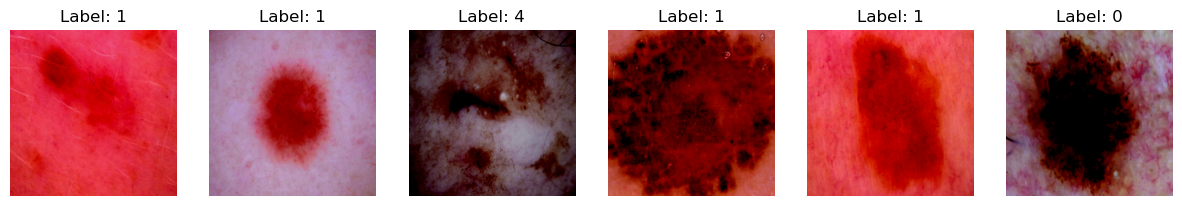

In [23]:
# Preprocess test ISIC images
test_images, test_labels = preprocess_isic_images(test_data_path, test_labels_df)
print("Test ISIC images Loaded")

# Convert train_lables to the range of 0 to 6
test_labels = torch.argmax(test_labels, dim=1)

# Plot test images with it's labels
def plot_images(images, labels, num_images=6):
    # Set the number of images to plot
#     num_images = min(num_images, images.size(0))
    
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 3))
    
    for i, ax in enumerate(axes.flat):
        if i >= num_images:
            break
        # Display image
        ax.imshow(images[i].permute(1, 2, 0))  # PyTorch tensors are in CxHxW format, but Matplotlib expects HxWxC
        ax.set_title(f"Label: {labels[i].numpy()}")
        ax.axis('off')
    
    plt.show()

# Assuming train_labels are your tensor of labels corresponding to each image
# Plot some of the images

plot_images(test_images, test_labels)

In [24]:
# Preprocess test sketch images
test_sketches = preprocess_sketch_images(test_sketch_path)
print("Test sketches Loaded.")

Test sketches Loaded.


In [26]:
print("test_images_normalized", test_images.size())
print("test_sketch_normalized", test_sketches.size())
# print("test_sketch_labels", test_sketch_labels.size())

test_images_normalized torch.Size([12, 3, 256, 256])
test_sketch_normalized torch.Size([10, 1, 256, 256])


In [27]:
# Test the model:
generator.eval()  # Set to evaluation mode

generated_images = []

batch_size = 64
# Test_Data_loading and testing loop
total_part_test_image_data = math.ceil(test_labels.size()[0]/test_sketches.size()[0])
# print("total_part_test_image_data: ", total_part_test_image_data)

# Create a image_label DataLoader
label_data_loader = DataLoader(TensorDataset(test_labels), batch_size=test_sketches.size()[0], shuffle=False)


with torch.no_grad():
    for i, batch_image_labels in enumerate(label_data_loader):
#         print("Image part:", i + 1)
        
        batch_image_labels = batch_image_labels[0] # Extracting the tensor from the tuple
        if batch_image_labels.size()[0] < test_sketches.size()[0]:
            batch_sketches = test_sketches[0 : batch_image_labels.size()[0]]

            # Create a TensorDataset
            dataset = TensorDataset(batch_image_labels, batch_sketches)

        else: 
            # Create a TensorDataset
            dataset = TensorDataset(batch_image_labels, test_sketches)

        # Create a DataLoader
        test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        for j, (tst_labels, sketches) in enumerate(test_loader):
#             print(sketches.size())
#             print(tst_labels.size())
            fake_images = generator(sketches, tst_labels.long())

            generated_images.append(fake_images)
            
#             print(f'Batch [{j+1}/{len(test_loader)}]')
#         print("")

print("Testing finished!")        

Testing finished!


In [28]:
generated_images_tensor = torch.cat(generated_images, dim=0)
print("Shape of generated images:", generated_images_tensor.shape)

Shape of generated images: torch.Size([12, 3, 256, 256])


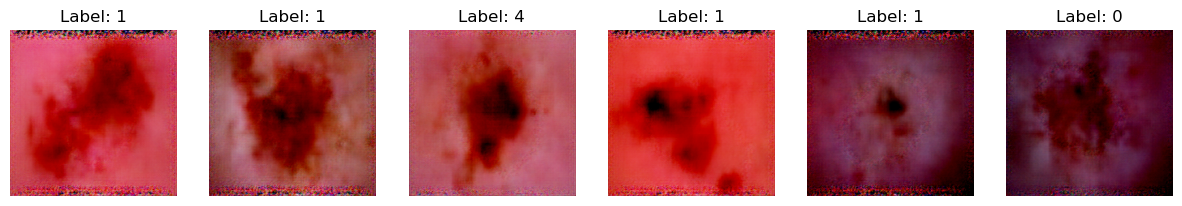

wandb: Network error (ConnectionError), entering retry loop.


In [29]:
def compute_fid_score(generated_images, test_images, batch_size=64):
    # Convert images to torch.uint8 data type
    generated_images = torch.tensor(generated_images, dtype=torch.uint8)
    test_images = torch.tensor(test_images, dtype=torch.uint8)

    # Load pre-trained Inception-v3 model
    inception_model = inception_v3(pretrained=True, transform_input=False)
    inception_model.eval()

    # Remove the final classification layer
    inception_model = nn.Sequential(*list(inception_model.children())[:-1])

    # Create FrechetInceptionDistance object
    fid_metric = FrechetInceptionDistance(feature=64)

    # Update FID metric with generated and real images
    fid_metric.update(generated_images, real=False)
    fid_metric.update(test_images, real=True)

    # Calculate FID score
    fid_score = fid_metric.compute()

    return fid_score

def visualize_images(images, labels, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, ax in enumerate(axes):
        # Convert to numpy array and transpose dimensions
        image_np = images[i].cpu().numpy().transpose(1, 2, 0)  # Transpose to (H, W, C)
        # Clip the pixel values to [0, 1] range
        image_np = np.clip(image_np, 0, 1)
        ax.imshow(image_np)
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')
    plt.show()

    
visualize_images(generated_images_tensor, test_labels)

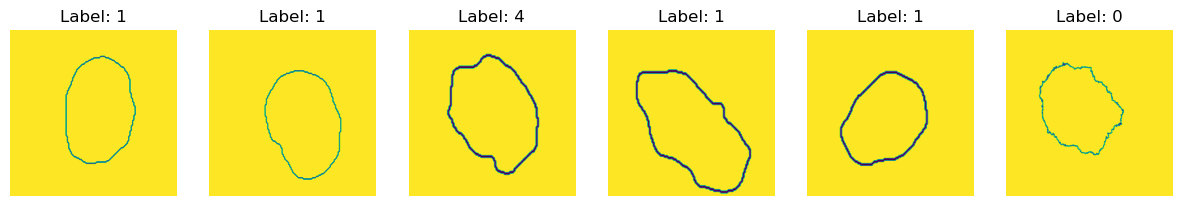

In [25]:
plot_images(test_sketches, test_labels, num_images=6)

In [ ]:
from tqdm import tqdm
from scipy.stats import entropy

def compute_is_score(images, batch_size=32, splits=1):
    # Load Inception V3 model
    model = inception_v3(pretrained=True, transform_input=True, aux_logits=True)
    model.eval()

    # Define transformations
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((299, 299)),
    ])

    # Calculate activations for real images
    preds = []
    for batch_start in tqdm(range(0, len(images), 64), desc="Calculating activations"):
        batch_images = images[batch_start:batch_start+batch_size]
        batch_images = [preprocess(img) for img in batch_images]
        batch_images = torch.stack(batch_images)
        pred = model(batch_images).detach().cpu().numpy()
        preds.append(pred)
    preds = np.concatenate(preds)

    # Calculate Inception Score
    scores = []
    for i in range(splits):
        part = preds[i * (preds.shape[0] // splits): (i + 1) * (preds.shape[0] // splits), :]
        p_yx = np.exp(part) / np.exp(part).sum(1, keepdims=True)
        p_y = np.exp(np.mean(part, axis=0)) / np.exp(np.mean(part, axis=0)).sum()
        scores.append(entropy(p_yx.T) + entropy(p_y))
    return np.mean(scores), np.std(scores)

In [ ]:
gen_img = generated_images_tensor.clone().numpy()
test_img = test_images.clone().numpy()
compute_is_score(gen_img)

In [ ]:
calculate_inception_score (test_img)

In [ ]:
fid_score = compute_fid_score(generated_images_tensor, test_images)
print("FID Score:", fid_score)

# Task : 3.2.2

In [ ]:
# Assuming you have original training and test data loaded as train_loader and test_loader
# and you have generated images and their corresponding labels as generated_images and generated_labels

# Define a classifier model
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

print("Model Defined!")

# Assuming num_classes is the number of classes in your dataset
num_classes = 7  # Modify this according to your dataset
classifier_model = Classifier(num_classes)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier_model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# # Train the model
# train_loader = DataLoader(TensorDataset(train_images, train_labels), batch_size=64, shuffle=True)

# # wandb.init(project="image_classifier", entity="m23air010")

# classifier_CrossEntropyLoss = []
# # Train the classifier on original training data
# def train_classifier(train_loader, model, criterion, optimizer, num_epochs=50):
#     model.train()
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         for inputs, labels in train_loader:
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             classifier_CrossEntropyLoss.append(loss)
#             # Log loss
# #             wandb.log({"cross_entropy_loss": loss.item()})
            
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item() * inputs.size(0)
#         epoch_loss = running_loss / len(train_loader.dataset)
#         print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# # Train the classifier
# print("Training Started.")
# train_classifier(train_loader, classifier_model, criterion, optimizer,num_epochs =500)
# print("Training Complete.")

In [ ]:
# Load Trained Classifier model
classifier_model.load_state_dict(torch.load('outputs/classifier_model.pth', map_location=torch.device('cpu')))

In [ ]:
# # Load data from JSON file
with open("outputs/classifier_CrossEntropyLoss.json", "r") as file:
    classifier_CrossEntropyLoss = json.load(file)

# Splitting into three parts
part1 = classifier_CrossEntropyLoss[:100*57]
part2 = classifier_CrossEntropyLoss[100*57: 2 * 100*57]
part3 = discriminator_losses[2 * 100*57:]

# Extract loss value for each epoch
img_part1_losses = part1[::57]
img_part2_losses = part2[::57]
img_part3_losses = part3[::45]

classifier_loss =[]
for i in range(100):
     classifier_loss.append((img_part1_losses[i] + img_part2_losses[i] +img_part2_losses[i])/3)

# Plot the graphs
plt.figure(figsize=(10, 6))

plt.subplot(1,1,1)
plt.plot(classifier_loss, label="classifier_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Classifier_CrossEntropyLoss")

In [ ]:
# Evaluate classifier accuracy on original test set
def evaluate_classifier(data_loader, model):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())
    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy

print("Testing Started.")
test_loader = DataLoader(TensorDataset(test_images, test_labels), batch_size=64, shuffle=True)
print("Testing Completed!")

In [ ]:
# Evaluate accuracy on original test set
original_test_accuracy = evaluate_classifier(test_loader, classifier_model)
print("Accuracy on original test set:", original_test_accuracy)

# Convert generated_images and it's labels to DataLoader
generated_dataset = TensorDataset(generated_images_tensor, test_labels)
generated_loader = DataLoader(generated_dataset, batch_size=batch_size, shuffle=True)

# Evaluate accuracy on generated images
generated_images_accuracy = evaluate_classifier(generated_loader, classifier_model)
print("Accuracy on generated images:", generated_images_accuracy)
